In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
from math import exp

In [13]:
GF_data = pd.read_csv('raw_data/Gruvefjellet_Res_data.dat', 
	skiprows = [0,2,3], index_col = 0,parse_dates = True, na_values = 'NAN', header = 0 ,
	names = ['TIMESTAMP','RECORD','ID','T10cm_minutt_Max','T10cm_minutt_Min','T10cm_minutt_Avg',
	'T1m_minutt_Max','T1m_minutt_Min','T1m_minutt_Avg',
	'T3m_minutt_Max','T3m_minutt_Min','T3m_minutt_Avg',
	'LF_minutt_Max','LF_minutt_Avg','p_mbar','ff_mps_Max','ff_10min',
	'ff_mps_avg', 'dd','NB_time','SD_m','SD_kval','TSS','T_soil_1m',
	'T_soil_2m','T_soil_3m','T_soil_4m','T_soil_5m','T_soil_6m',
	'R_surf_ohm','R_1m_ohm', 'R_2m_ohm', 'R_3m_ohm', 'R_4m_ohm',
	'R_5m_ohm', 'R_6m_ohm', 'Batt_V_Min'])

GF_data = GF_data['2016-08-01 00:00:00':'2017-04-30 23:00:00']

#HIER DIE KORREKTUR VON RELATIVE HUMIDITY FUER MESSUNGEN UEBER WASSER/EIS

#----------------------Correct relative humidity for T<0-----------------------------------------
# need RH above ice for T<0 because we can expect the ground and surface water etc.. to be frozen,
# most probably RH values are raw data without correction...

# Create empty DataFrame
RH_calc_GF=pd.DataFrame({'DateTime':GF_data.index,'e_s':np.nan,'e':np.nan,
                         'absH': np.nan, 'RH_corr':np.nan, 'RH':GF_data.LF_minutt_Avg})
RH_calc_GF.set_index('DateTime',inplace = True, drop=True)
Lv = 2.5*10**6 #Jkg**(-1) Latent heat of vaporisation
Ls = 2.8*10**6 #Jkg**(-1) Latent heat of sublimation
Rv = 462 #J(kgK)**-1 individual gas constant for water vapor
T0 = 273.15 #K reference Temperature

for i in range(0,len(GF_data.index)):
	# Calculation of saturation water vapor pressure over water for given temperature from AWS
	RH_calc_GF.e_s[i] = 611* exp((Lv/Rv*((1/T0)-(1/(GF_data.T1m_minutt_Avg[i]+273.15)))))
	# Calculation of actual water vapor pressure	
	RH_calc_GF.e[i] = (GF_data.LF_minutt_Avg[i]*RH_calc_GF.e_s[i])/100
	# Calculation of the absolute humidity 
	RH_calc_GF.absH[i] = RH_calc_GF.e[i]/(Rv*(GF_data.T1m_minutt_Avg[i]+273.15))
	# print(RH_calc_GF.absH[i])
	# If the temperature is below 0 degrees the saturation water vapor pressure over ice is needed
	if GF_data.T1m_minutt_Avg[i] <0:
	# For these cases overwrite the previous calculation by saturation over ice
		RH_calc_GF.e_s[i] = 611* exp((Ls/Rv*((1/T0)-(1/(GF_data.T1m_minutt_Avg[i]+273.15)))))
	# Calculate relative Humidity from actual water vapor pressure and saturation water vapor pressure with corrected values for T<0
	RH_calc_GF.RH_corr[i] = (RH_calc_GF.e[i]/RH_calc_GF.e_s[i])*100	
	# Set RH>100 to 100
	if RH_calc_GF.RH_corr[i] > 100:
		RH_calc_GF.RH_corr[i] = 100
        
# SAME PROCEDURE FOR DATA FROM AD!!!



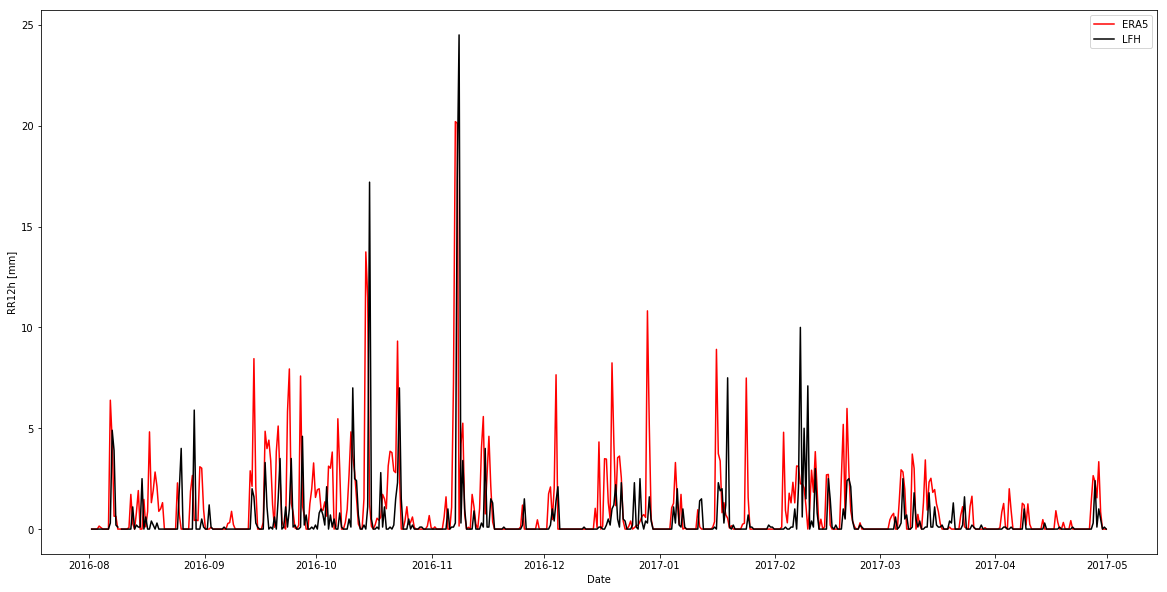

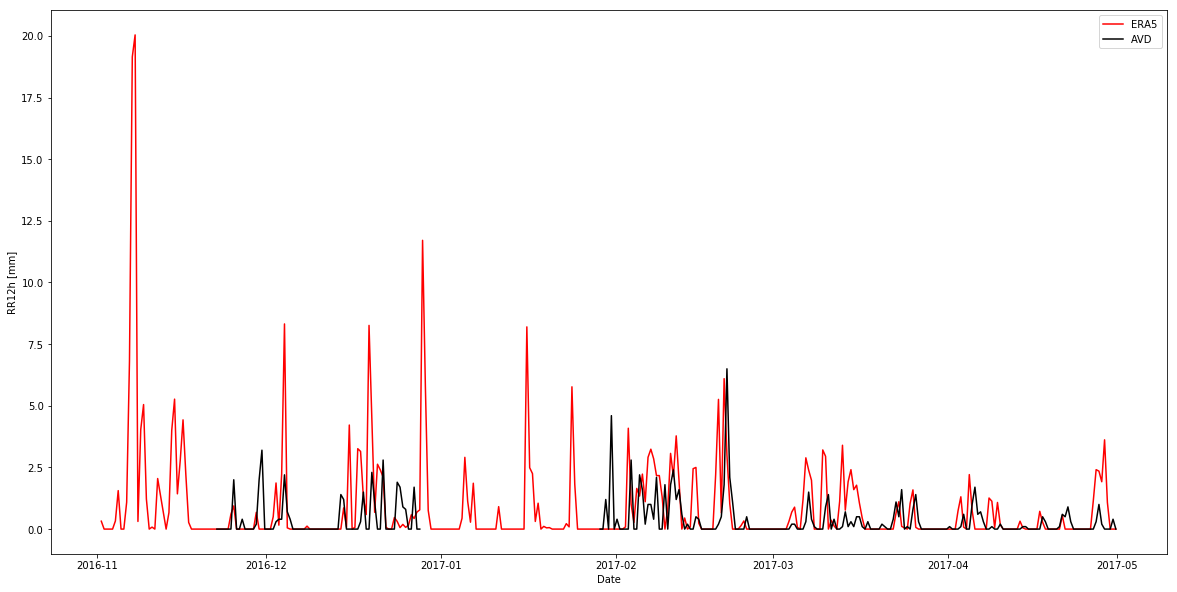

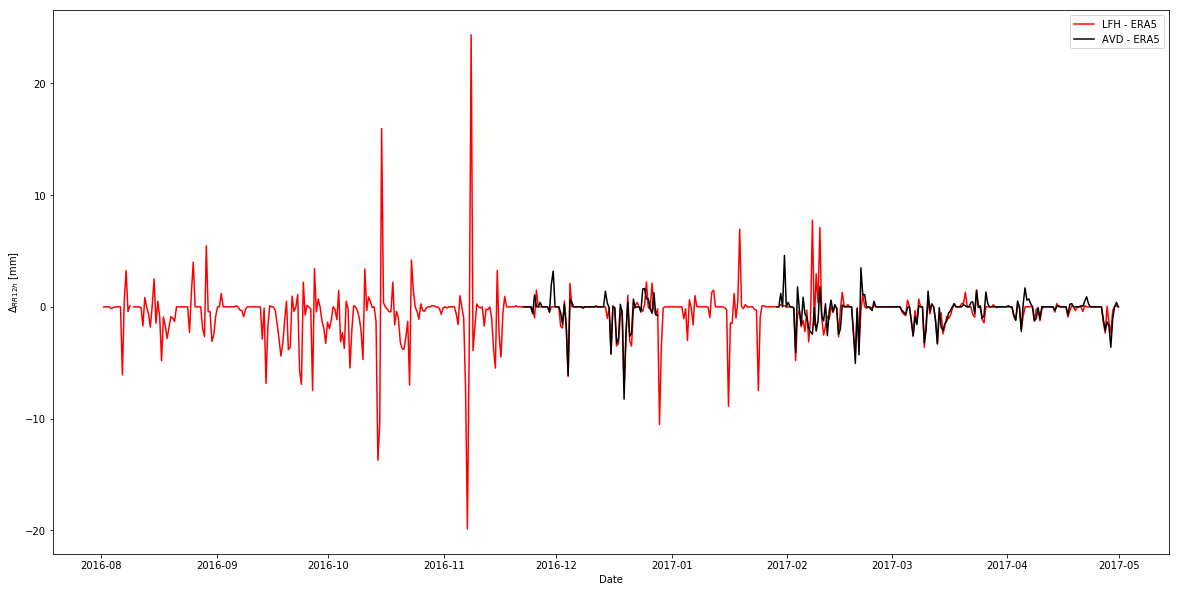

(736177.0, 736449.0)

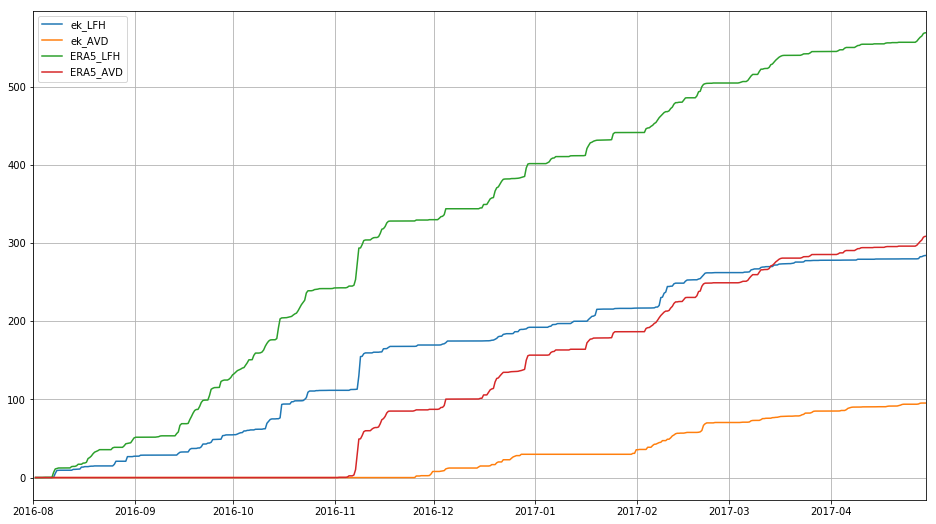

In [17]:
# BISHERIGE VERSUCHE EINEN SCHNELLEN UEBERBLICK UEBER DEN NIEDERSCHLAG ZU BEKOMMEN

# Load datasets:
# Note: ek = eklima data, RR1h = Precipitation data with 1h resolution, 
# RR12h = Precipitation data with 12h resolution, gives the sum of the 12h before
ek_LFH = pd.read_csv('data/LFH_RR_ts.txt', na_values = 'NaN')
ek_LFH.DateTime = pd.to_datetime(ek_LFH.DateTime)
ek_LFH.set_index('DateTime',inplace=True)

ek_AVD = pd.read_csv('data/AVD_RR_ts.txt', na_values = 'NaN')
ek_AVD.DateTime = pd.to_datetime(ek_AVD.DateTime)
ek_AVD.set_index('DateTime',inplace=True)

# For comparison between ERA5 and LFH use same date as for Gruvefjellet (GF) because
# nearest grid point in ERA5 is the same
ERA5_RR1h_LFH = pd.read_csv('data/ERA5_GF.txt', na_values = 'NaN')
ERA5_RR1h_LFH['DateTime'] = pd.to_datetime(ERA5_RR1h_LFH['DateTime'])
ERA5_RR1h_LFH.set_index('DateTime',inplace=True)

# For comparison between ERA5 and AVD
ERA5_RR1h_AVD = pd.read_csv('data/ERA5_AVD.txt', na_values = 'NaN')
ERA5_RR1h_AVD['DateTime'] = pd.to_datetime(ERA5_RR1h_AVD['DateTime'])
ERA5_RR1h_AVD.set_index('DateTime',inplace=True)

# Get 12h sum at 06Z and 18Z for ERA5 data, also take care of units conversion. 
# ERA5 data originally is hourly accumulation [m], ek data is 12h accumulation in [mm]
# Change unit of ERA5 data to [mm] ([m/12h])
ERA5_RR12h_LFH = ERA5_RR1h_LFH.RRmm.resample('12H', base = 6).sum()#.multiply(10**3)
ERA5_RR12h_LFH = ERA5_RR12h_LFH['2016-08-01 18:00:00':'2017-04-30 18:00:00']
ERA5_RR12h_AVD = ERA5_RR1h_AVD.RRmm.resample('12H', base = 6).sum()#.multiply(10**3)
ERA5_RR12h_AVD = ERA5_RR12h_AVD['2016-11-01 18:00:00':'2017-04-30 18:00:00']
ek_LFH = ek_LFH['2016-08-01 18:00:00':'2017-04-30 18:00:00']
ek_AVD = ek_AVD['2016-11-01 18:00:00':'2017-04-30 18:00:00']

diff_LFH_ERA5 = ek_LFH.RR - ERA5_RR12h_LFH
diff_AVD_ERA5 = ek_AVD.RR - ERA5_RR12h_AVD
diff_AVD_ERA5_SE = diff_AVD_ERA5**2
diff_LFH_ERA5_SE = diff_LFH_ERA5**2
diff_AVD_ERA5_MSE = diff_AVD_ERA5_SE.mean()
diff_LFH_ERA5_MSE = diff_LFH_ERA5_SE.mean()

plt.figure(figsize = (20,10))
plt.plot(ERA5_RR12h_LFH,'r-', label = 'ERA5')
plt.plot(ek_LFH.RR,'k-', label = 'LFH')
plt.legend()
plt.xlabel('Date')
plt.ylabel('RR12h [mm]')

plt.figure(figsize = (20,10))
plt.plot(ERA5_RR12h_AVD,'r-', label = 'ERA5')
plt.plot(ek_AVD.RR,'k-', label = 'AVD')
plt.legend()
plt.xlabel('Date')
plt.ylabel('RR12h [mm]')

plt.figure(figsize = (20,10))
plt.plot(diff_LFH_ERA5,'r-',label = 'LFH - ERA5')
plt.plot(diff_AVD_ERA5,'k-',label = 'AVD - ERA5')
plt.legend()
plt.xlabel('Date')
plt.ylabel(r'$\Delta_{RR12h}$ [mm]')
plt.show()

# Plot akkumulierter Niederschlag

precip = pd.DataFrame()
precip['ERA5_12H_LFH'] = ERA5_RR12h_LFH
precip['ERA5_12H_AVD'] = ERA5_RR12h_AVD
precip['ek_LFH'] = ek_LFH.RR
precip['ek_AVD'] = ek_AVD.RR

plt.figure(figsize = (16,9))
ns_ek_LFH = precip['ek_LFH'].tolist()
ns_sum_ekLFH = [np.nansum(ns_ek_LFH[0:i]) for i in range(len(ns_ek_LFH))]
plt.plot(precip.index, ns_sum_ekLFH,label = 'ek_LFH')

ns_ek_AVD = precip['ek_AVD'].tolist()
ns_sum_ekAVD = [np.nansum(ns_ek_AVD[0:i]) for i in range(len(ns_ek_AVD))]
plt.plot(precip.index, ns_sum_ekAVD,label = 'ek_AVD')

ns_ERA5_LFH = precip['ERA5_12H_LFH'].tolist()
ns_sum_ERALFH = [np.nansum(ns_ERA5_LFH[0:i]) for i in range(len(ns_ERA5_LFH))]
plt.plot(precip.index, ns_sum_ERALFH,label = 'ERA5_LFH')

ns_ERA5_AVD = precip['ERA5_12H_AVD'].tolist()
ns_sum_ERA5AVD = [np.nansum(ns_ERA5_AVD[0:i]) for i in range(len(ns_ERA5_AVD))]
plt.plot(precip.index, ns_sum_ERA5AVD,label = 'ERA5_AVD')
plt.legend()
plt.grid(which='major')
plt.xlim([dt.date(2016,8,1),dt.date(2017,4,30)])